Current Time = 15:49:17
img shape=  (512, 512)
K = 2, T = 3
V*_pq x V_pq( 0,   0) =  0.9989799270805745
V*_pq x V_pq( 1,  -1) =  0.9989596088128032
V*_pq x V_pq( 1,   1) =  0.9989596088128032
V*_pq x V_pq( 2,  -2) =  0.9989392952006408
V*_pq x V_pq( 2,   0) =  0.9989393091674672
V*_pq x V_pq( 2,   2) =  0.9989392952006408
V*_pq x V_pq( 3,  -3) =  0.9989189862480361
V*_pq x V_pq( 3,  -1) =  0.9989190235244925
V*_pq x V_pq( 3,   1) =  0.9989190235244925
V*_pq x V_pq( 3,   3) =  0.9989189862480361
Plotting .... 


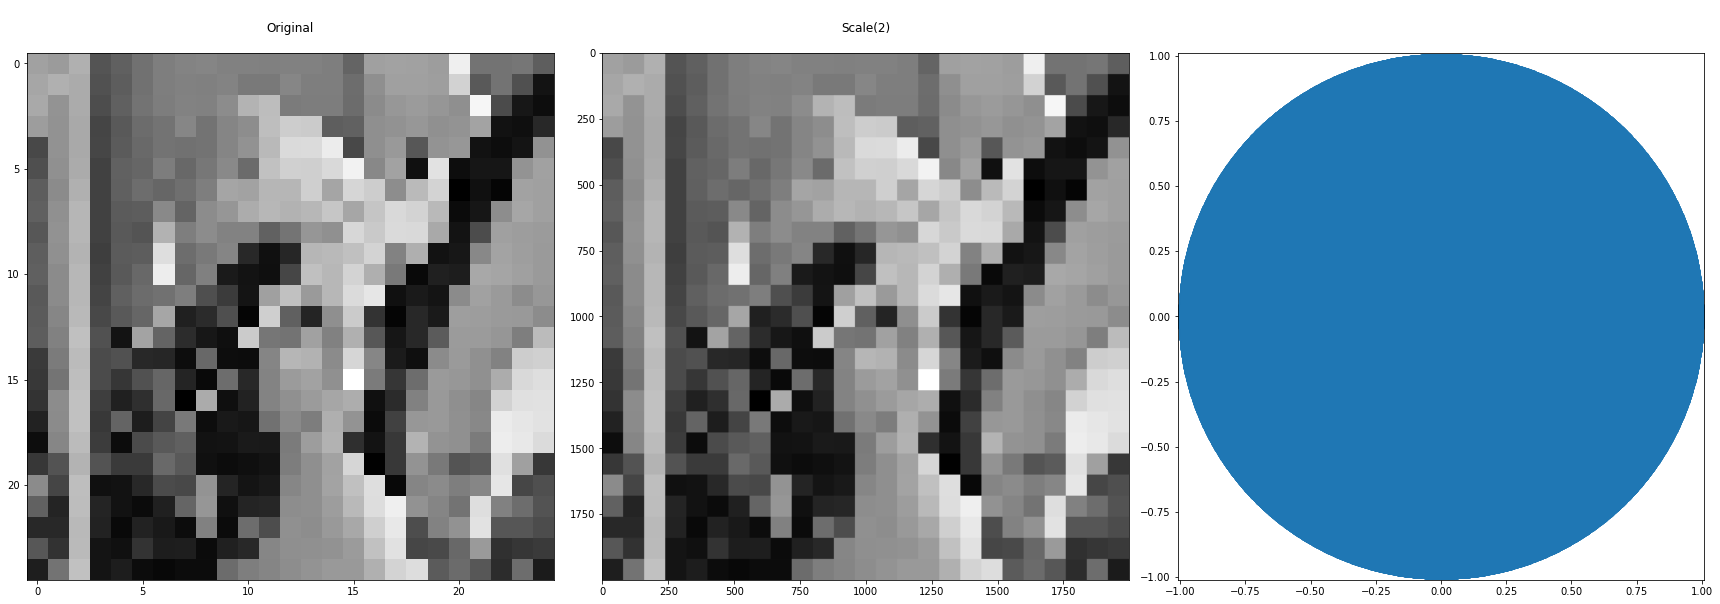

Current Time = 15:49:21

Done.
Wall time: 3.96 s


In [13]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

print_curr_time()

debug = 0

img = cv.imread( 'image/lenna.png', 0 )

shape = img.shape
width = 25

if shape[0] > shape[1] :    
    img = cv.resize( img, (width, shape[0]*width//shape[1]) )
else :
    img = cv.resize( img, (shape[1]*width//shape[0], width) )
pass

print( "img shape= ", shape )

img_org = img 

K = 2
s = 1_000*K

use_gpu = 1
use_hash = 1

np = cupy if use_gpu else cupy

img = cv.resize( img_org, (s, s), interpolation=cv.INTER_AREA )
img = np.array( img )

rho, theta, x, y, dx, dy, k = rho_theta( img, use_gpu=use_gpu, debug = debug) 

T = 3
print( f"K = {K}, T = {T}" )
hash = {}
for p in range( 0, T + 1 ) : 
    for q in range( -p, p + 1 ) :
        if (p - abs(q))%2 == 1 : continue  
    
        v_pq = Vpq( p, q, rho, theta, use_gpu, hash=hash, use_hash=use_hash, debug=0 )
        sum = np.sum( v_pq*np.conjugate(v_pq) ) 
        sum = sum*dx*dy*(p + 1)/pi 
        sum = np.absolute( sum )
        print( f"V*_pq x V_pq({p:2d}, {q:3d}) = ", sum )
    pass
pass

del hash

print( "Plotting .... ")

# 서브 챠트 생성 
idx = 0 
row_cnt = 1; col_cnt = 3
fig, charts = plt.subplots( row_cnt, col_cnt, figsize=( 8*col_cnt, 8*row_cnt) )
charts = charts.flatten()

t_img = cupy.asnumpy( img_org )
chart = charts[ idx ] ; idx += 1
chart.set_title( "\nOriginal\n" )
chart.imshow( t_img, cmap='gray' )

if 0 : 
    chart.set_xlim( 0 , t_img.shape[1] - 1 )
    chart.set_ylim( 0 , t_img.shape[0] - 1 ) 
    chart.set_yticks( np.arange( 0, t_img.shape[1]))
    chart.set_yticks( np.arange( 0, t_img.shape[0])[::-1])

t_img = cupy.asnumpy( img )
chart = charts[ idx ] ; idx += 1
chart.set_title( f"\nScale({K})\n" )
chart.imshow( t_img, cmap='gray' )

if 0 : 
    chart.set_xlim( 0 , t_img.shape[1] - 1 )
    chart.set_ylim( 0 , t_img.shape[0] - 1)
    chart.set_yticks( np.arange( 0, t_img.shape[1]))
    chart.set_yticks( np.arange( 0, t_img.shape[0])[::-1])

chart = charts[ idx ] ; idx += 1
chart.set_aspect(1)
m = 0.01
chart.set_xlim( -1 - m , 1 + m )
chart.set_ylim( -1 - m , 1 + m )
if 0 : 
    chart.axhline(y=0, color='k')
    chart.axvline(x=0, color='k')

chart.add_artist( plt.Circle((0, 0), 1, fill=0) )
x = cupy.asnumpy(x)
y = cupy.asnumpy(y)
chart.scatter( x, y, marker="." )

plt.tight_layout(); plt.show()

print_profile()

print_curr_time()

print( "\nDone." )